In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

# Final model for 180 dataset

In [10]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [11]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [12]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [13]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [14]:
model_180 = FetchModel("space_miss").compile()

In [15]:
data_180 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_180'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances
}

fit_180 = model_180.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_180 = az.from_cmdstanpy(fit_180)

04:49:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:54:24 - cmdstanpy - INFO - CmdStan done processing.
04:54:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_miss.stan', line 45, column 4 to column 65)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_miss.stan', line 45, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_miss.stan', line 45, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_miss.stan', line 45, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1]

In [16]:
post_pred = PostPred(posterior_180, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

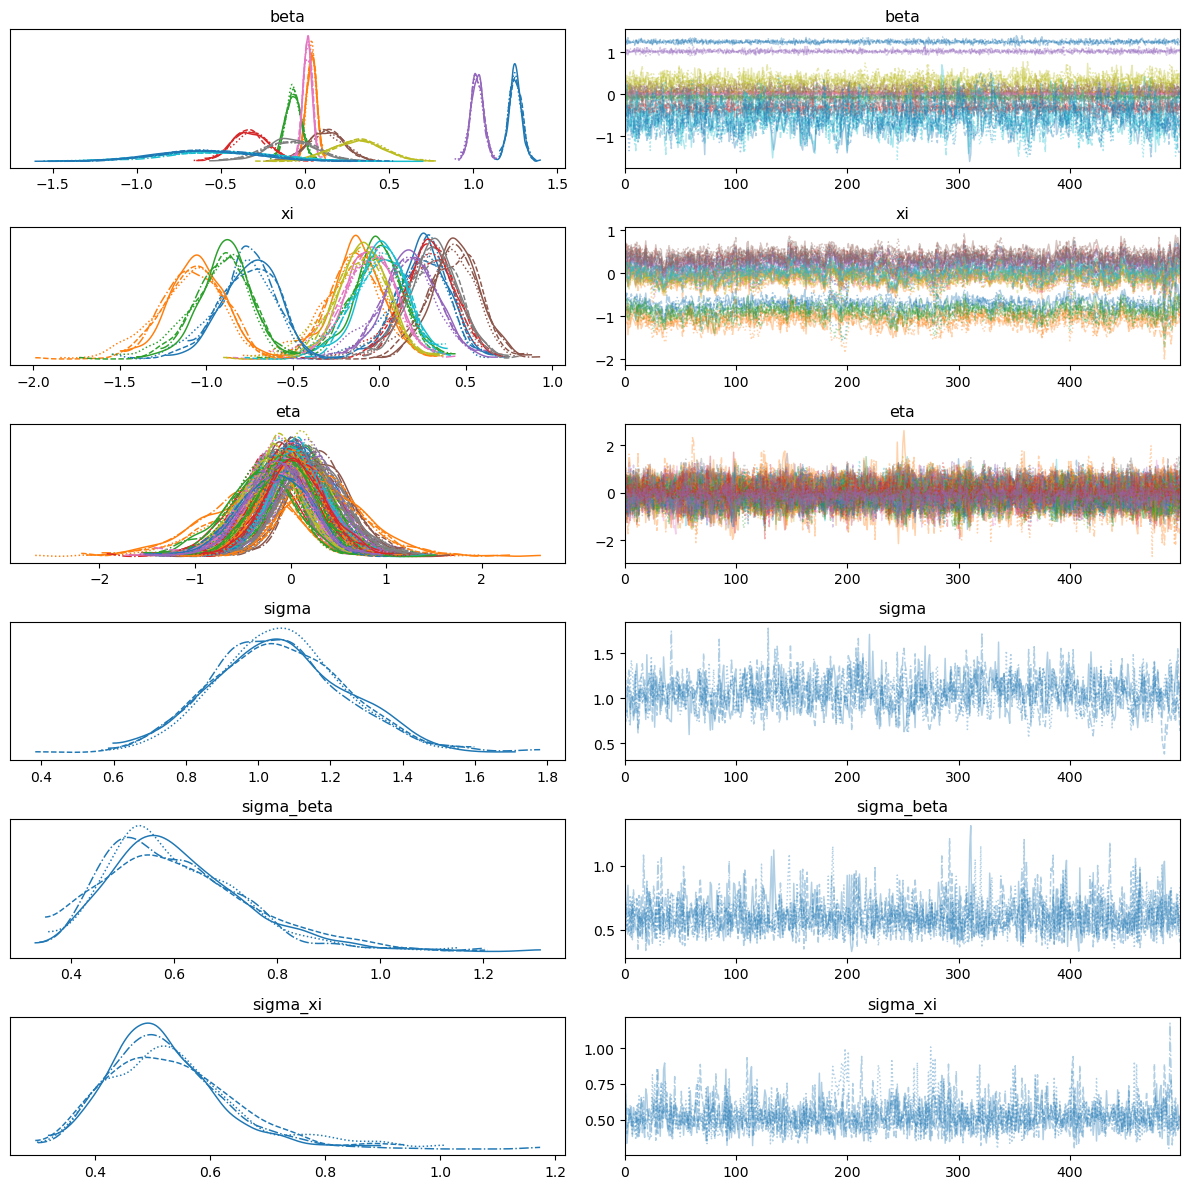

In [17]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [18]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3838.77    84.70
p_waic      105.73        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3839.39    84.73
p_loo      106.35        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3807  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [19]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [20]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  74   78  125  150  160  187  193  233  365  372  384  402  403  441
  474  475  529  579  602  656  675  676  778  798  851  867  872  873
  907 1043 1078 1093 1122 1156 1157 1262 1337 1366 1380 1394 1427 1524
 1532 1539 1568 1618 1619 1658 1748 1780 1813 1821 1832 1878 1935 1973
 2110 2127 2135 2224 2240 2331 2338 2350 2371 2377 2384 2389 2440 2449
 2458 2492 2518 2532 2561 2562 2569 2595 2646 2650 2672 2679 2691 2705
 2725 2738 2750 2769 2817 2829 2851 2877 2879 2911 2997 3030 3044 3087
 3100 3185 3220 3222 3226 3227 3260 3272 3330 3375 3400 3401 3443 3486
 3507 3560 3610 3626 3663 3668 3723 3743 3770]

The total number of outliers is: 121

The MSE is: 2.2308298319327733

The MAE is: 0.7198004201680672

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9682247899159664



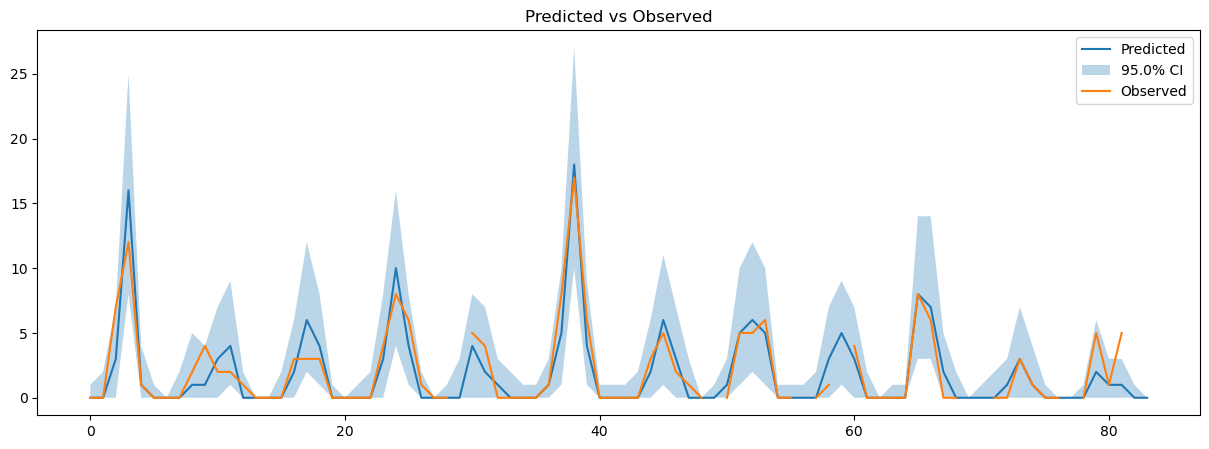

In [21]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

# Final model for 120 dataset

In [22]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [23]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [24]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [25]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [26]:
months_to_repeat = [7]
dummy_july = np.zeros(X.shape[0])
idx_july = np.where(Y['Month'].isin(months_to_repeat))[0]
dummy_july[idx_july] = 1
dummy_july_obs = pd.Series(dummy_july[idx_obs])
dummy_july_miss = pd.Series(dummy_july[idx_miss])


In [27]:
model_120 = FetchModel("space_dummy_rej").compile()

In [28]:
data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_july_obs,
    "dummy_miss": dummy_july_miss
}

fit_120 = model_120.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120 = az.from_cmdstanpy(fit_120)

04:55:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

05:06:36 - cmdstanpy - INFO - CmdStan done processing.
05:06:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy_rej.stan', line 58, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy_rej.stan', line 58, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_d

In [29]:
post_pred = PostPred(posterior_120, Y['Count_120'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

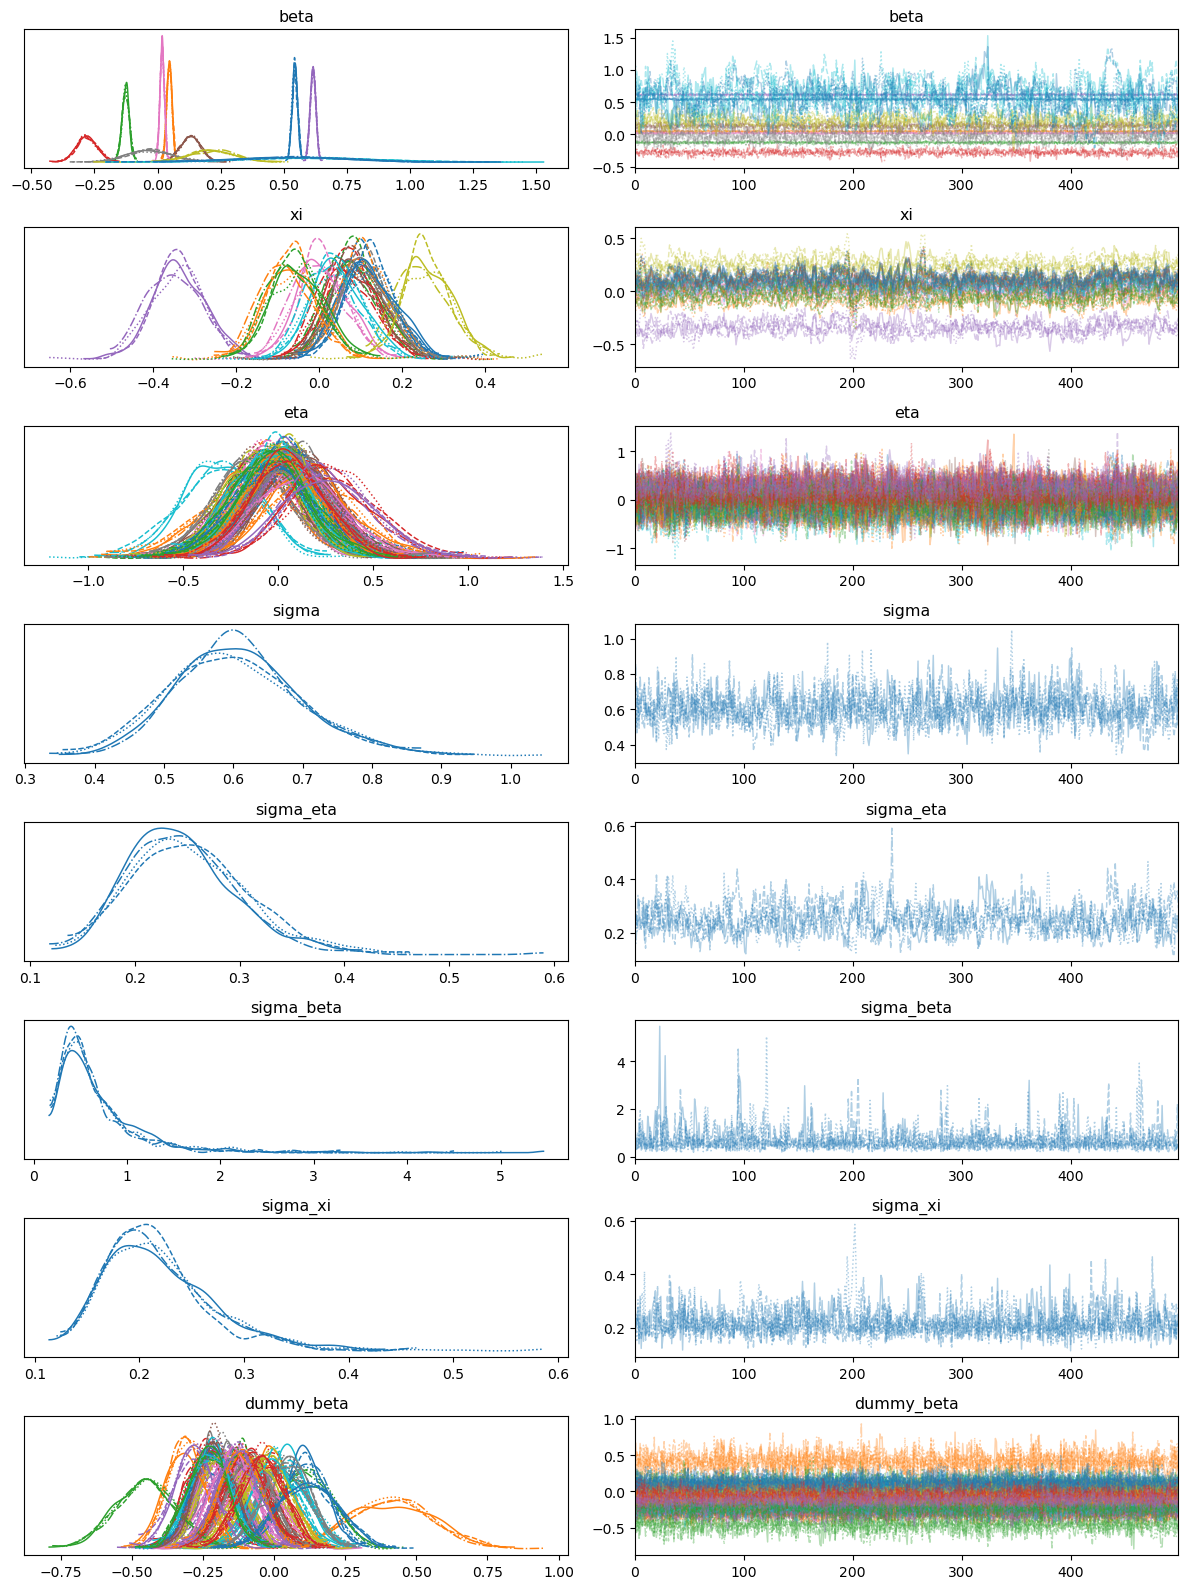

In [30]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi', 'dummy_beta'])
plt.tight_layout()
plt.show()

In [31]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10061.87    86.83
p_waic      158.56        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10063.01    86.86
p_loo      159.70        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3837   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [32]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [33]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   83  145  154  165  173  227  234  309  350  351  362  363  385
  391  394  396  404  410  413  414  420  422  429  430  433  472  477
  478  479  481  482  486  488  493  512  513  519  581  582  585  599
  609  618  643  648  650  662  665  669  680  682  685  689  690  695
  701  718  749  753  757  769  770  771  774  775  777  781  787  799
  802  807  824  835  842  863  864  869  874  876  877  884  898  917
  918  919  920  921  925  931  950  955  962  984 1012 1016 1019 1021
 1022 1026 1032 1042 1043 1053 1073 1105 1118 1146 1158 1165 1168 1179
 1185 1195 1222 1283 1329 1331 1341 1371 1384 1385 1407 1408 1449 1457
 1527 1535 1540 1552 1553 1559 1563 1611 1631 1667 1765 1774 1786 1824
 1848 1859 1867 1869 1874 1880 1889 1897 1903 1912 1923 1953 1955 1960
 1978 1982 1983 1989 2026 2029 2050 2075 2076 2089 2110 2115 2119 2127
 2134 2137 2140 2144 2180 2198 2221 2227 2228 2234 2238 2251 2274 2291
 2301 2315 2327 2332 2363 2367 2375 2382 2398 2399 2406 2430 2458 2

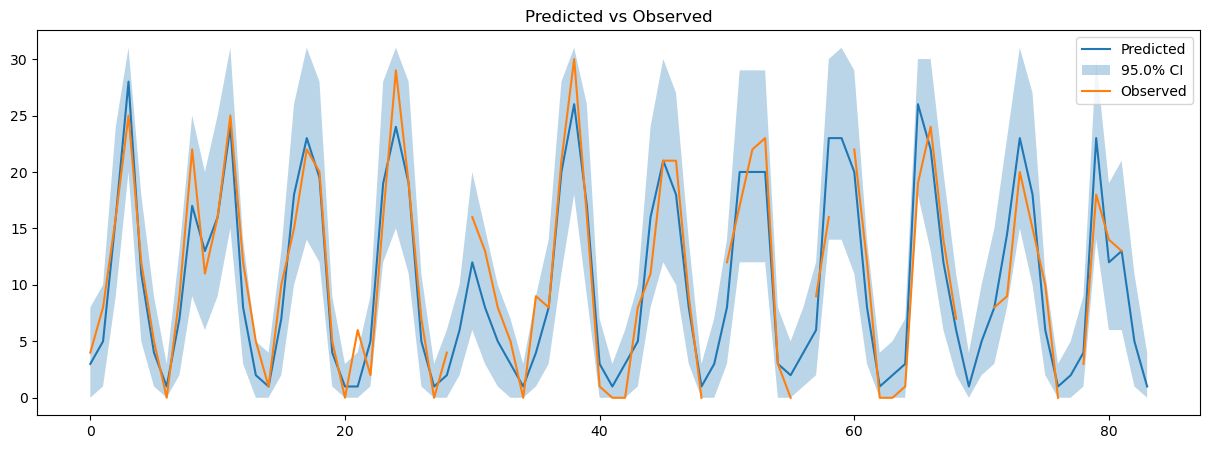

In [34]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()